# Туториал №1: релаксация структуры

Активация окружения (?)

Установка библиотек:

In [ ]:
# !pip install ipykernel # by terminal
!pip install siman
!pip install py3Dmol

Входные настройки:

In [4]:
import sys

from siman import header
from siman.header import printlog, runBash

from siman.SSHTools import SSHTools
from siman.calc_manage   import (smart_structure_read, update_des, add_loop, res_loop, add, res, complete_run)
from siman.database      import read_database, write_database
from siman.set_functions import read_vasp_sets


header.conv, header.varset, size_on_start = read_database()
header.struct_des = update_des(header.struct_des, header.MANUALLY_ADDED); 
db                = header.db 

import project_sets # should be after read_database
project_path = %pwd # here we read the path to the directory of that notebook and write it to the variable
header._update_configuration(f'{project_path}/simanrc.py', pfolder=f'{project_path}')

save = 1

## Постановка задачи

Релаксация структуры методом теории функционала плотности (ТФП/DFT) может выполняться для различных целей. Здесь мы рассмотрим, как использовать этот инструмент в качестве вспомогательного для разрешения экспериментальных данных дифракционного паттерна (PXRD).

Для начала разберем модельный пример.  
При разрешении структуры, содержащей Li, методом PXRD позиции Li могут быть определены неточно. Здесь мы проведем релаксацию ячейки кристалла LiF, начав со структуры со сдвинутыми атомами Li в заведомо неоптимальные позиции - такая структура будет играть роль неточно разрешенной экспериментальной. 

#### 1. Релаксация LiF со сдвинутыми атомами Li

##### Подготовительная часть

In [ ]:
# Cкачиваем структуру с Materials Project
from mp_api.client import MPRester
your_key = # your_key
with MPRester(api_key=your_key) as mpr:
    data = mpr.materials.search(material_ids=["mp-1138"])[0].structure

/home/mrkraev/SK/siman/ICYS/test/venv-2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4132.32it/s]


In [6]:
# Преобразуем в ase.atoms для удобства работы
from pymatgen.io.ase import AseAtomsAdaptor

adaptor = AseAtomsAdaptor()
atoms = adaptor.get_atoms(data)

In [7]:
# Выводим информацию о структуре
print('Химическая формула:', atoms.get_chemical_formula())
print('Позиции атомов:')
for i in range(len(atoms)):
    print('     ', atoms[i].symbol, atoms[i].position)
print('Элементарная ячейка: ', atoms.get_cell())

Химическая формула: FLi
Позиции атомов:
      Li [0. 0. 0.]
      F [1.667052  1.178784  2.8874195]
Элементарная ячейка:  Cell([[2.500578, 0.0, 1.44371], [0.833526, 2.357568, 1.44371], [0.0, 0.0, 2.887419]])


In [8]:
# Cоздаём структуру со сдвинутыми атома лития
atoms_shifted = atoms.copy()
atoms_shifted[0].scaled_position = [0.1, 0.2, 0.15] # относительные координаты 

In [9]:
# Выводим информацию о модифицированной структуре
print('Химическая формула:', atoms_shifted.get_chemical_formula())
print('Позиции атомов:')
for i in range(len(atoms_shifted)):
    print('     ', atoms_shifted[i].symbol, atoms_shifted[i].position)
print('Элементарная ячейка: ', atoms_shifted.get_cell())

Химическая формула: FLi
Позиции атомов:
      Li [0.416763   0.4715136  0.86622585]
      F [1.667052  1.178784  2.8874195]
Элементарная ячейка:  Cell([[2.500578, 0.0, 1.44371], [0.833526, 2.357568, 1.44371], [0.0, 0.0, 2.887419]])


In [10]:
# Записываем данные о структурах в .cif файлы для последующей визуализации
from ase.io import write

filename = 'LiF.cif'
write(filename, images = atoms)

filename = 'LiF_shifted.cif'

write(filename, images = atoms_shifted)

In [11]:
# Визуализируем начальную структуру
import py3Dmol

with open('LiF.cif', 'r') as f:
    cif_data = f.read()

viewer = py3Dmol.view(width=300, height=300)
model = viewer.addModel(cif_data, 'cif')

viewer.addUnitCell()

viewer.setStyle({'sphere': {'scale': 0.3}, 'stick': {'radius': 0.1}})
viewer.setBackgroundColor('white')
viewer.zoomTo()

viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
# Визуализируем модифицированную структуру
with open('LiF_shifted.cif', 'r') as f:
    cif_data = f.read()

viewer = py3Dmol.view(width=300, height=300)
model = viewer.addModel(cif_data, 'cif')

viewer.addUnitCell()

viewer.setStyle({'sphere': {'scale': 0.3}, 'stick': {'radius': 0.1}})
viewer.setBackgroundColor('white')
viewer.zoomTo()

viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

##### Создание входных файлов для релаксации структуры в VASP: POSCAR, INCAR, POTCAR, KPOINTS

In [38]:
# Cтруктура (POSCAR)
st = smart_structure_read(input_geo_file='LiF_shifted.cif') 

In [14]:
# Параметры расчета, используемый обменно-корреляционный фукнционал, псевдопотенциал 
# (INCAR, POTCAR, KPOINTS)

varset = read_vasp_sets(project_sets.user_vasp_sets, override_global = 0)
print('Набор параметров для оптимизации электронной плотности на заданной конфигурации ядер: ')
for param in ['EDIFF', 'ENCUT', 'KSPACING', 'NSW']:
    print(param, varset['static_light'].params[param]);

Набор параметров для оптимизации электронной плотности на заданной конфигурации ядер: 
EDIFF 0.0001
ENCUT 400
KSPACING 0.3
NSW 0


In [15]:
# Создаём набор для релаксации структуры
read_vasp_sets([('ion_relax_light', 'static_light', {'NSW':25, 'EDIFFG':-0.025, 'ISIF':2, 'IBRION':2})])

varset['ion_relax_light'].potdir = {3:"Li_sv", 9:"F"}

counter = 1
for param in varset['ion_relax_light'].params:
    value = varset['ion_relax_light'].params[param]
    if value != None: 
        print(f'{counter}: ', param, value) 
        counter += 1
# Прочитайте описание неизвестных параметров на VASP Wiki

1:  ISTART 0
2:  NELM 50
3:  EDIFF 0.0001
4:  NSW 25
5:  PREC Normal
6:  ALGO Normal
7:  ENCUT 400
8:  ENAUG 700.0
9:  KSPACING 0.3
10:  KGAMMA .TRUE.
11:  LREAL Auto
12:  ISMEAR 0
13:  SIGMA 0.1
14:  LPLANE .TRUE.
15:  NPAR 1
16:  mul_nbands_small_cell 3
17:  IBRION 2
18:  ISIF 2
19:  EDIFFG -0.025


In [37]:
# Запускаем расчет на кластере
add('LiF', 'ion_relax_light', 1, input_st = st, it_folder = './tut1', corenum = 4, run = 2)

-- Attention!, cluster None is not found, using default raz 

-- Warning! This calculation was already submitted. Use run = 2 to submit it again 

-- Warning! run = 2, the calculation is resubmitted 

-- check_kpoints(): Kpoint   mesh is:  [9, 9, 9] 

-- check_kpoints(): The actual k-spacings are  ['0.30', '0.30', '0.30'] 

-- POSCAR was written to ./tut1//LiF.ion_relax_light/1.POSCAR 

-- Attention! ngkpt =  [9, 9, 9]  is adopted from struct_des which you provided for it  LiF  and kspacing =  0.3 


Calculation db[('LiF', 'ion_relax_light', 1)] successfully created

 

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             29464       gpu gpu_test d.cherny  R    2:45:16      1 gpu01
             29427   regular Fe15Al_c   a.boev  R    6:43:05      1 node03
             29425   regular Fe15Al_c   a.boev  R    6:43:29      1 node03
             29424   regular Fe15Si_c   a.boev  R    6:43:41      1 node03
             29423   regular Fe15Si_c   a.boev  R   

'LiF'

##### Работа с результатом

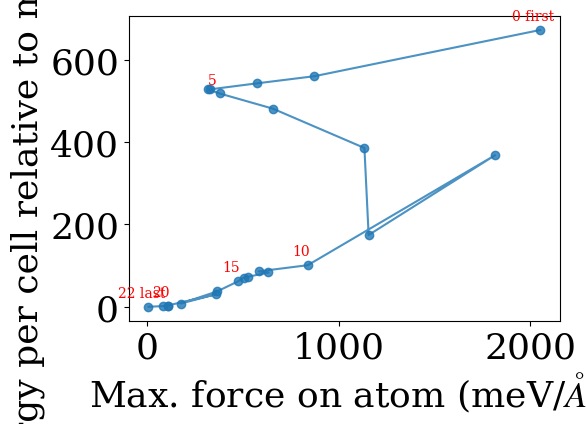

-- db['LiF.ion_relax_light.1']   | Fm-3m |  -9.7187   |  -4.8593   |2.89, 2.89, 2.89|  17.0  |  0  |-12768,-12796,-12560 | 2  | 0.069  |  23, 4,103   |  0  | 1 | 0.0 |  -0| -1.7  

Database has been successfully updated



In [39]:
# Считываем результаты с выводом графика для максимальной силы и энергии в зависимости от шага релаксации
res('LiF', 'ion_relax_light', 1, show = 'en'); 

<>:24: SyntaxWarning: invalid escape sequence '\A'
<>:24: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_3839/3142427145.py:24: SyntaxWarning: invalid escape sequence '\A'
  xlabel = 'Max. force on atom (meV/$\AA$)', ylabel = 'Energy per cell relative to min (meV)', fontsize = 12,


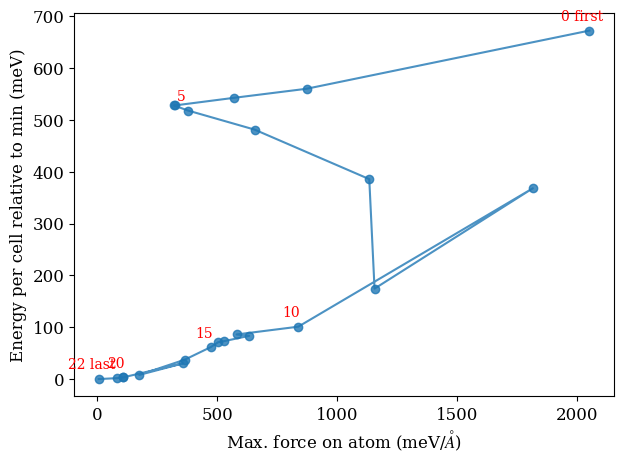

In [41]:
# Перерисовываем график 
import matplotlib.pyplot as plt
import numpy as np
data = db['LiF.ion_relax_light.1']
energies = (np.array(data.list_e_sigma0) - data.list_e_sigma0[-1]) * 1000 # смотрим на энергию относительно последней структуры, в мэВ
forces = np.array(data.maxforce_list).T[1]

numbers = list(range(len(forces)))
annotates = []
for n in numbers:
    if n%5 == 0 or n == len(numbers)-1:
        if n == 0:
            annotates.append(str(n)+' first')
        elif n == len(numbers)-1:
            annotates.append(str(n)+' last')
        else:
            annotates.append(n)
    else:
        annotates.append('')

from siman.picture_functions import fit_and_plot
fit_and_plot(data = {'x': forces, 'y':energies, 'fmt':'-o', 
                    'annotates': annotates, 'annotate_fontsize':10, 'annotate_arrowprops':None}, annotate = 1,
                    xlabel = 'Max. force on atom (meV/$\AA$)', ylabel = 'Energy per cell relative to min (meV)', fontsize = 12,
                    show = 1);

In [42]:
# Записываем отрелаксированную структуру в .cif файл для последующей визуализации
from ase.io import read
atoms_shifted_relaxed = read('tut1/LiF.ion_relax_light/1.CONTCAR')
write(filename ='./LiF_shifted_relaxed.cif', images = atoms)

In [43]:
# Визуализируем отрелаксированную структуру
with open('LiF_shifted_relaxed.cif', 'r') as f:
    cif_data = f.read()

viewer = py3Dmol.view(width=300, height=300)
model = viewer.addModel(cif_data, 'cif')

viewer.addUnitCell()

viewer.setStyle({'sphere': {'scale': 0.3}, 'stick': {'radius': 0.1}})
viewer.setBackgroundColor('white')
viewer.zoomTo()

viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [44]:
# Выводим позиции атомов для отрелаксированной структуры
atoms_shifted_relaxed.get_scaled_positions()
# Совпадает ли вывод ли ожидаемым результатом?

array([[0.04976573, 0.10004732, 0.07503364],
       [0.55023427, 0.59995268, 0.57496636]])

In [45]:
# Смещаем все атомы на фиксированный вектор, возвращая фтор на позицию (0.5, 0.5, 0.5)
diff = np.array([0.5, 0.5, 0.5]) - atoms_shifted_relaxed[1].scaled_position
print('Смещение атома фтора:', diff)
for n in range(len(atoms_shifted_relaxed)):
    atoms_shifted_relaxed[n].scaled_position += diff
    print(atoms_shifted_relaxed[n].symbol, atoms_shifted_relaxed[n].scaled_position)

Смещение атома фтора: [-0.05023427 -0.09995268 -0.07496636]
Li [-4.68544057e-04  9.46344546e-05  6.72812032e-05]
F [0.5 0.5 0.5]


##### Расчет XRD паттерна и сравнение с экспериментальным

In [46]:
# Считываем структуры в формате pymatgen.core.Structure
from pymatgen.core import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
 
structure_shifted = Structure.from_file('./LiF_shifted.cif')
structure_shifted_relaxed = Structure.from_file('LiF_shifted_relaxed.cif')
xrd = XRDCalculator(wavelength='CuKa') # initiate XRD calculator (can specify various options here)

In [47]:
# Выводим координаты Li для обеих структур
structure_shifted[0].coords, structure_shifted_relaxed[0].coords, 

(array([0.416763  , 0.4715136 , 0.86622585]), array([0., 0., 0.]))

<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_3839/2879561665.py:6: SyntaxWarning: invalid escape sequence '\T'
  ax1.set_xlabel('$2 \Theta $');
/tmp/ipykernel_3839/2879561665.py:12: SyntaxWarning: invalid escape sequence '\T'
  ax2.set_xlabel('$2 \Theta $');


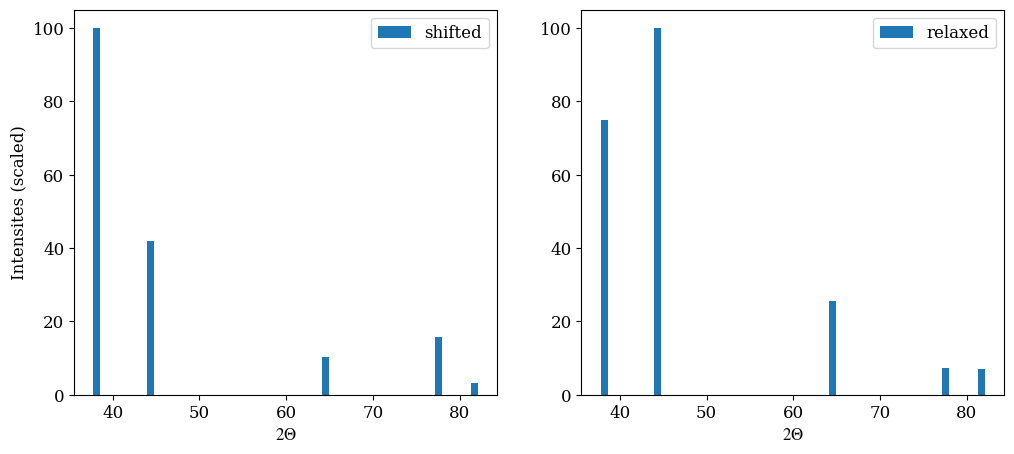

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

pattern = xrd.get_pattern(structure_shifted)
ax1.bar(pattern.x, pattern.y, label = 'shifted')
ax1.legend();
ax1.set_xlabel('$2 \Theta $');
ax1.set_ylabel('Intensites (scaled)')

pattern = xrd.get_pattern(structure_shifted_relaxed)
ax2.bar(pattern.x, pattern.y, label = 'relaxed')
ax2.legend()
ax2.set_xlabel('$2 \Theta $');

Экспериментальный паттерн:

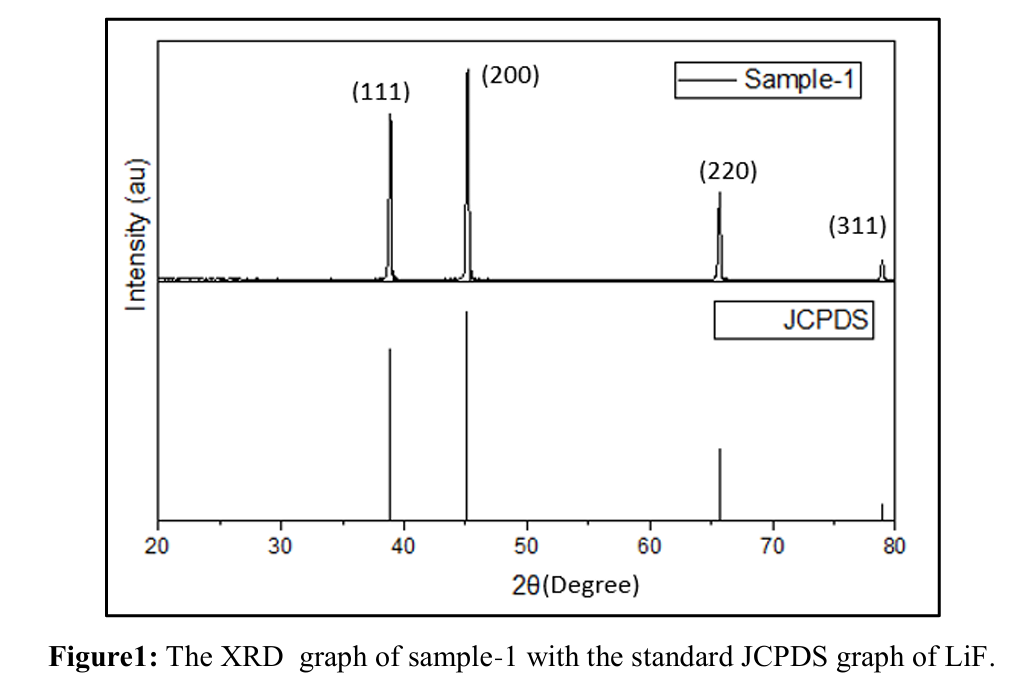

In [ ]:
# Замечание о поиске локального минимума, а не глобального
# Повторение с другой начальной структурой: а) другим сдвигом и б) другим объемом (замечание о Pulay stress*), 
# в) экспериментальной структурой

In [ ]:
# Разговор о точности стандратного PBE, сходимости по параметрам и сравнении с экспериментом

#### 2. Часть Арсения

Сохранение данных о расчетах и созданного набора параметров:

In [ ]:
"""End working"""
complete_run(header.close_run)


if save:
    write_database(db, header.conv, header.varset, size_on_start)